Loading data

In [ ]:
import pandas as pd
df = pd.read_csv('conversationo.csv')
raw = df.dropna().reset_index(drop=True)#remove nan column
raw

,Question,answer
0,hey,Hello! How may I help you.
1,do u have coffee,"Yes sir Simple Coffee ,Cappuchino, Americano,..."
2,i will take one espresso and 5 americano,Sir thanks for your order. You have ordered 1 ...
3,anything special,"We have coffe,pastries,puff pastries and milks..."
4,suggest something,"We have coffe,pastries,puff pastries and milks..."
...,...,...
932,what is price of French Coffee,"Its our one of best, you can enjoy it at just ..."
933,what is price of Iced Coffee Late,"Its our one of best, you can enjoy it at just ..."
934,what is price of Latte Macchiato,"Its our one of best, you can enjoy it at just ..."
935,what is price of Wainans Choco Coffee,"Its our one of best, you can enjoy it at just ..."


In [ ]:

!pip install plotly
!pip install gensim
!pip install kneed
!pip install imblearn

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px

#Libraries for preprocessing
from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

#Download once if using NLTK for preprocessing
import nltk
nltk.download('punkt')

#Libraries for vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation



#Libraries for clustering
from sklearn.cluster import KMeans

#Load data set for clustering
text1 = raw['answer']



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Preprocessing
- remove stopswords,punctuation

In [ ]:
lst_que = [remove_stopwords(x)\
        .translate(str.maketrans('','',string.punctuation))\
        for x in text1]
        

- Stemming and making words lower case






In [ ]:
from gensim.utils import save_as_line_sentence
#Stem and make lower case
def clean_data(sentence):
    porter = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return ' '.join(stem_sentence)


clean_ques = pd.Series([clean_data(x) for x in lst_que])


Feature Engineering 
- BOW

In [ ]:
vectorizer_cv = CountVectorizer(analyzer='word')
X_cv = vectorizer_cv.fit_transform(clean_ques)


# Clustering Process
- find the optimal number of clusters

18


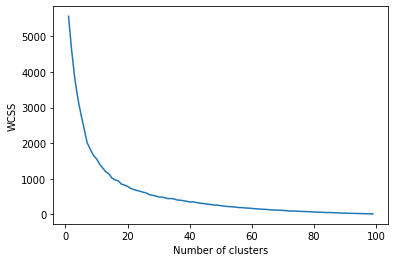

In [ ]:
from kneed import KneeLocator
number_of_clusters = 100
wcss = []
for i in range (1, number_of_clusters):
  model = KMeans(n_clusters=i, 
  init='k-means++', 
  max_iter=100, # Maximum number of iterations of the k-means algorithm for a single run.
  )  # Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
  model.fit(X_cv)
  wcss.append(model.inertia_)
kl = KneeLocator(range(1, 100), wcss, curve="convex", direction="decreasing")
print(kl.elbow)
plt.plot(range(1, number_of_clusters), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
#Create 21 clusters
kmeans = KMeans(n_clusters=21)
kmeans.fit(X_cv)
result = pd.concat([text1,pd.DataFrame(X_cv.toarray(),columns=vectorizer_cv.get_feature_names())],axis=1)
result['cluster'] = kmeans.predict(X_cv)
result

,answer,150,180,189,190,200,250,americano,americanopleas,answer,...,way,we,wellingtonketo,what,whi,white,would,ye,you,cluster
0,Hello! How may I help you.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,10
1,"Yes sir Simple Coffee ,Cappuchino, Americano,...",0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,6
2,Sir thanks for your order. You have ordered 1 ...,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,4
3,"We have coffe,pastries,puff pastries and milks...",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,12
4,"We have coffe,pastries,puff pastries and milks...",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,"Its our one of best, you can enjoy it at just ...",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14
933,"Its our one of best, you can enjoy it at just ...",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14
934,"Its our one of best, you can enjoy it at just ...",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14
935,"Its our one of best, you can enjoy it at just ...",0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
clusters = result['cluster'].unique()
labels = []
for i in range(len(clusters)):
    subset = result[result['cluster'] == clusters[i]]
    words = ' '.join([x for x in np.where(subset.all()!=0,subset.columns,None) if x and x!='answer' and x!='cluster' and len(x.split()) == 1])
    labels.append(words)
labels_table = pd.DataFrame(zip(clusters,labels),columns=['cluster','label'])
result_labelled = pd.merge(result,labels_table,on='cluster',how='left')
new_table = result_labelled[['cluster','label']]
new_table.insert(0,'Question',raw['Question'])
new_table.insert(1,'Answer',raw['answer'])
new_table
# new_table.to_csv(r'data1.csv',index = False, header=True)

,Question,Answer,cluster,label
0,hey,Hello! How may I help you.,10,hello help
1,do u have coffee,"Yes sir Simple Coffee ,Cappuchino, Americano,...",6,americano au black cappucchino cappuchino chan...
2,i will take one espresso and 5 americano,Sir thanks for your order. You have ordered 1 ...,4,order sir thank you
3,anything special,"We have coffe,pastries,puff pastries and milks...",12,have like milkshakeswhat
4,suggest something,"We have coffe,pastries,puff pastries and milks...",12,have like milkshakeswhat
...,...,...,...,...
932,what is price of French Coffee,"Its our one of best, you can enjoy it at just ...",14,180 best enjoy it rs
933,what is price of Iced Coffee Late,"Its our one of best, you can enjoy it at just ...",14,180 best enjoy it rs
934,what is price of Latte Macchiato,"Its our one of best, you can enjoy it at just ...",14,180 best enjoy it rs
935,what is price of Wainans Choco Coffee,"Its our one of best, you can enjoy it at just ...",1,best enjoy it rs


# Classification


## Data Preprocessing

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime,timedelta
import warnings 
warnings.filterwarnings('ignore') # to ignore deprecated functions

In [ ]:
df=pd.read_excel("data1_new_2.xlsx")

In [ ]:
df.head()

,Question,Answer,cluster,label
0,what is price of Black Coffee,"Its our one of best, you can enjoy it at just ...",1.0,3.10 CAD
1,what is price of Black Coffee,"Its our one of best, you can enjoy it at just ...",1.0,3.10 CAD
2,what is price of Espresso,"Its our one of best, you can enjoy it at just ...",1.0,3.10 CAD
3,what is price of Espresso,"Its our one of best, you can enjoy it at just ...",1.0,3.10 CAD
4,what is price of Chans Espresso,"Its our one of best, you can enjoy it at just ...",1.0,3.10 CAD


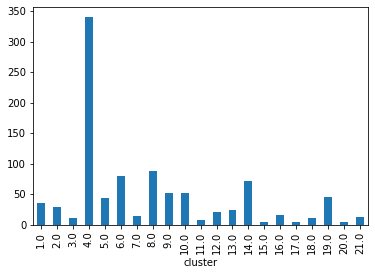

In [ ]:
#Count Plot :- to see if the dataset is balanced or not
target = df.groupby('cluster')['cluster'].count()
target.plot.bar()


In [ ]:
target

cluster
1.0      36
2.0      28
3.0      10
4.0     340
5.0      44
6.0      80
7.0      14
8.0      88
9.0      52
10.0     52
11.0      8
12.0     20
13.0     24
14.0     72
15.0      4
16.0     16
17.0      4
18.0     10
19.0     46
20.0      4
21.0     12
Name: cluster, dtype: int64

In [ ]:
import nltk
import json
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
import numpy as np
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re
import string
import random
import warnings

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


In [ ]:
lemmatizer = WordNetLemmatizer()
warnings.filterwarnings("ignore")
#random.seed(1)
data=df['Question']
data

0        what is price of Black Coffee
1        what is price of Black Coffee
2            what is price of Espresso
3            what is price of Espresso
4      what is price of Chans Espresso
                    ...               
959                how much is  Tanuki
960         how much is  Simple Coffee
961          how much is Simple Coffee
962                how much is  Tanuki
963         how much is  Simple Coffee
Name: Question, Length: 964, dtype: object

In [ ]:
data_X = df['Question'].values.tolist()
y = df['cluster']
data_y = df['cluster'].values.tolist()
classes= df['cluster'].drop_duplicates().values.tolist()
classes = sorted(set(classes))
print(data_X)
print(len(data_X))
print(data_y)
print(classes)
print(len(classes))

['what is price of Black Coffee', 'what is price of Black Coffee', 'what is price of Espresso', 'what is price of Espresso', 'what is price of Chans Espresso', 'what is price of Chans Espresso', 'what is price of Con Panna', 'what is price of Black Coffee', 'what is price of Espresso', 'what is price of Black Coffee', 'what is price of Black Coffee', 'what is price of Espresso', 'what is price of Espresso', 'what is price of Chans Espresso', 'what is price of Chans Espresso', 'what is price of Con Panna', 'what is price of Black Coffee', 'what is price of Espresso', 'how much is Black Coffee', 'how much is Black Coffee', 'how much is Espresso', 'how much is Espresso', 'how much is Chans Espresso', 'how much is Chans Espresso', 'how much is Con Panna', 'how much is Black Coffee', 'how much is Espresso', 'how much is Black Coffee', 'how much is Black Coffee', 'how much is Espresso', 'how much is Espresso', 'how much is Chans Espresso', 'how much is Chans Espresso', 'how much is Con Panna

In [ ]:
words = []
data=df['Question']
for i in data:
  tokens = nltk.word_tokenize(i)
  words.extend(tokens)

words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in string.punctuation]
words = sorted(set(words))
print(words)


['11:00', '2', '2-4-20', '3', '5', 'a', 'americano', 'and', 'anything', 'apple', 'asparagus', 'at', 'au', 'avoo', 'banana', 'basque', 'beef', 'black', 'blaeter', 'blueberry', 'bluree', 'book', 'caffe', 'cake', 'can', 'candy', 'cappucchino', 'cappuchino', 'caramel', 'cerame', 'chans', 'char', 'cheery', 'cheese', 'cherry', 'choco', 'chocolate', 'cinnimon', 'coffee', 'combo', 'con', 'cotton', 'cranberry', 'cream', 'cupcake', 'do', 'drumstick', 'easy', 'egg', 'espresso', 'excuse', 'extra', 'for', 'forest', 'frappe', 'french', 'fruit', 'get', 'give', 'good', 'have', 'hello', 'hey', 'honey', 'how', 'i', 'ice-cream', 'iced', 'in', 'irish', 'is', 'juice', 'keto', 'laite', 'late', 'latte', 'layer', 'like', 'macchiato', 'macron', 'malted', 'mango', 'maxres', 'me', 'menu', 'milkshake', 'mint', 'mix', 'mose', 'much', 'need', 'nutella', 'of', 'ok', 'on', 'one', 'orange', 'oreo', 'panna', 'pastery', 'pastry', 'peanut', 'pineapple', 'pista', 'please', 'pomegranate', 'pretze', 'pretzel', 'price', 'puf

In [ ]:
training = []
dataset = []
out_empty = [0]*len(classes)
for idx, doc in enumerate(data_X):
  bow = []
  text = lemmatizer.lemmatize(doc.lower())
  for word in words: 
    bow.append(1) if word in text else bow.append(0)

  output_row = list(out_empty)
  #print(output_row)
  output_row[classes.index(data_y[idx])] = 1
  #out = data_y[idx]
  #print(out)
  training.append([bow, output_row])
  dataset.append([bow, output_row])

#print((training[0]))
dataset = np.array(dataset, dtype= object)
X = np.array(list(dataset[:,0]))

#random.shuffle(training)
training = np.array(training, dtype= object)

train = np.array(list(training[:,0]))
test = np.array(list(training[:,1]))

## Handle imbalance 

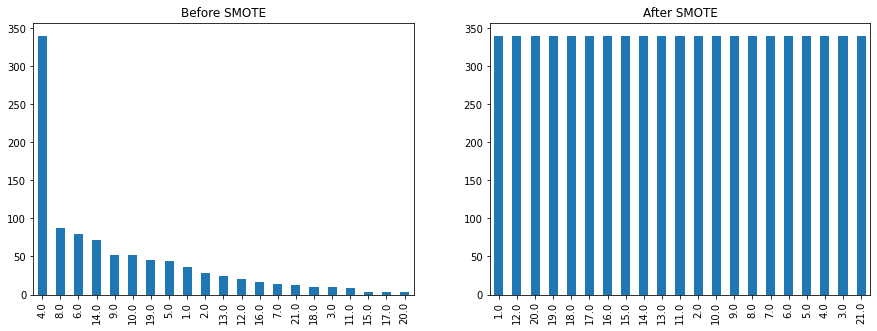

In [ ]:
from imblearn.over_sampling import SMOTE # SMOTE
sm = SMOTE(random_state=777, k_neighbors=3)
X_sm, y_sm = sm.fit_resample(X, y.ravel())

# to demonstrate the effect of SMOTE over imbalanced datasets
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(15, 5))
ax1.set_title('Before SMOTE')
pd.Series(y).value_counts().plot.bar(ax=ax1)

ax2.set_title('After SMOTE')  
pd.Series(y_sm).value_counts().plot.bar(ax=ax2)

plt.show()

In [ ]:
sm = SMOTE(random_state=777, k_neighbors=3)
train_sm, test_sm = sm.fit_resample(train, test)


## Split data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.2,random_state=42)

In [ ]:
X_train.shape, y_train.shape

((5712, 160), (5712,))

In [ ]:
X_test.shape, y_test.shape

((1428, 160), (1428,))

In [ ]:
train_X, test_X, train_Y, test_y = train_test_split(train_sm, test_sm, test_size = 0.2,random_state=42)

In [ ]:
train_X.shape, train_Y.shape

((5712, 160), (5712, 21))

In [ ]:
test_X.shape, test_y.shape

((1428, 160), (1428, 21))

In [ ]:
print(test_y)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Naive Bayes

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-2, num=100)
}
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)

In [ ]:
nbModel_grid.fit(X_train, y_train)
best_model_nb = nbModel_grid.best_estimator_
best_model_nb

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


GaussianNB(var_smoothing=0.01)

In [ ]:
nb_pred=best_model_nb.predict(X_test)
print("Training accuracy: {}".format(nbModel_grid.best_score_))

Training accuracy: 0.901606493331537


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
dt = DecisionTreeClassifier(random_state=42)

In [ ]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [5, 10, 20,25,50],
    'min_samples_leaf': [10, 20, 50, 100,120],
    'criterion': ["gini", "entropy"]
}

In [ ]:
grid_search_dt = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=10, n_jobs=-1, verbose=1, scoring = "accuracy")

In [ ]:
grid_search_dt.fit(X_train, y_train)
best_model_dt = grid_search_dt.best_estimator_
best_model_dt

Fitting 10 folds for each of 50 candidates, totalling 500 fits


DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=10,
                       random_state=42)

In [ ]:
dt_pred=best_model_dt.predict(X_test)
print("Training accuracy: {}".format(grid_search_dt.best_score_))

Training accuracy: 0.9320704689356176


## Deep Learning Model

In [ ]:
#Neural Network Classification

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics


In [ ]:
def create_model():
  model = Sequential()
  model.add(Dense(128, input_shape= (train_X.shape[1],), activation = "relu"))
  model.add(Dropout(0.5))

  model.add(Dense(64,activation="relu"))
  model.add(Dropout(0.5))

  model.add(Dense(train_Y.shape[1],activation = "softmax"))
  adam = Adam(learning_rate=0.01,decay = 1e-6)
  model.compile(loss='categorical_crossentropy',optimizer = adam, metrics= ["accuracy"])
  return model


In [ ]:
model=create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               20608     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 21)                1365      
                                                                 
Total params: 30,229
Trainable params: 30,229
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
90/90 [==============================] - 1s 6ms/step - loss: 1.0949 - accuracy: 0.6541 - val_loss: 0.2054 - val_accuracy: 0.9342
Epoch 2/50
90/90 [==============================] - 0s 4ms/step - loss: 0.3690 - accuracy: 0.8720 - val_loss: 0.1481 - val_accuracy: 0.9433
Epoch 3/50
90/90 [==============================] - 0s 4ms/step - loss: 0.2899 - accuracy: 0.8976 - val_loss: 0.1226 - val_accuracy: 0.9524
Epoch 4/50
90/90 [==============================] - 0s 4ms/step - loss: 0.2491 - accuracy: 0.9097 - val_loss: 0.1263 - val_accuracy: 0.9559
Epoch 5/50
90/90 [==============================] - 1s 10ms/step - loss: 0.2377 - accuracy: 0.9154 - val_loss: 0.1202 - val_accuracy: 0.9489
Epoch 6/50
90/90 [==============================] - 1s 9ms/step - loss: 0.2138 - accuracy: 0.9231 - val_loss: 0.1114 - val_accuracy: 0.9531
Epoch 7/50
90/90 [==============================] - 0s 3ms/step - loss: 0.2153 - accuracy: 0.9205 - val_loss: 0.1079 - val_accuracy: 0.9587
Epoch 8/50
90/90 [=

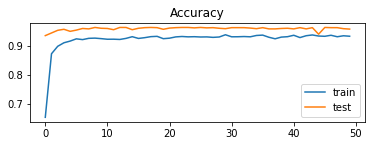

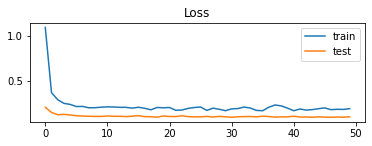


The accuracy and loss of the Neural Network classifier on test data is 0.96 and 0.10



In [ ]:
from matplotlib import pyplot

hist=model.fit(train_X, train_Y, validation_data=(test_X, test_y), batch_size=64, epochs=50, verbose=1)
print('accuracy and loss\n')
 
acc = hist.history['accuracy']
loss = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

pyplot.subplot(211)
pyplot.title('Accuracy')
pyplot.plot(acc, label='train')
pyplot.plot(val_acc, label='test')
pyplot.legend()
pyplot.show()

pyplot.subplot(212)
pyplot.title('Loss')
pyplot.plot(loss, label='train')
pyplot.plot(val_loss, label='test')
pyplot.legend()
pyplot.show()

loss, accuracy = model.evaluate(test_X, test_y, verbose=0)
print("\nThe accuracy and loss of the Neural Network classifier on test data is {:.2f} and {:.2f}\n".format(accuracy, loss))

# Evaluation

## Naive Bayes

Classification Report is:
               precision    recall  f1-score   support

         1.0       0.85      0.91      0.88        74
         2.0       0.99      1.00      0.99        79
         3.0       1.00      1.00      1.00        76
         4.0       1.00      1.00      1.00        75
         5.0       1.00      1.00      1.00        70
         6.0       0.78      1.00      0.88        65
         7.0       0.83      1.00      0.91        68
         8.0       0.66      0.94      0.77        63
         9.0       1.00      1.00      1.00        71
        10.0       1.00      0.72      0.84        68
        11.0       1.00      1.00      1.00        80
        12.0       0.87      0.44      0.58        59
        13.0       1.00      0.82      0.90        65
        14.0       1.00      0.86      0.92        64
        15.0       1.00      1.00      1.00        76
        16.0       0.78      0.84      0.81        61
        17.0       1.00      1.00      1.00        70


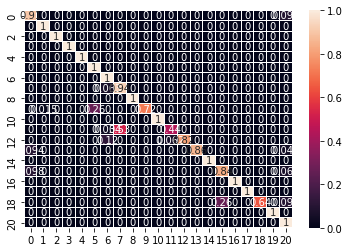

In [ ]:
print("Classification Report is:\n",classification_report(y_test,nb_pred))

print("Training accuracy: {}".format(nbModel_grid.best_score_))
confusion_nb = confusion_matrix(y_test,nb_pred)

cm_normalized_nb = confusion_nb.astype('float') / confusion_nb.sum(axis=1)[:, np.newaxis]

print("\n Confusion Matrix:\n")
sns.heatmap(cm_normalized_nb, annot=True, linewidths = 0.01)


## Decision Tree

Classification Report is:
               precision    recall  f1-score   support

         1.0       1.00      0.91      0.95        74
         2.0       0.99      1.00      0.99        79
         3.0       1.00      1.00      1.00        76
         4.0       0.98      0.81      0.89        75
         5.0       0.97      1.00      0.99        70
         6.0       0.93      1.00      0.96        65
         7.0       0.96      1.00      0.98        68
         8.0       0.70      0.98      0.82        63
         9.0       1.00      1.00      1.00        71
        10.0       1.00      0.88      0.94        68
        11.0       0.98      1.00      0.99        80
        12.0       1.00      0.53      0.69        59
        13.0       1.00      1.00      1.00        65
        14.0       0.80      0.83      0.82        64
        15.0       1.00      1.00      1.00        76
        16.0       0.90      0.90      0.90        61
        17.0       1.00      1.00      1.00        70


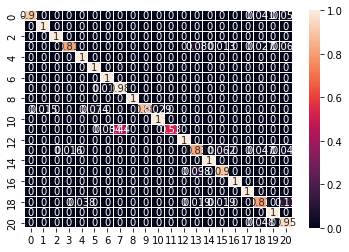

In [ ]:
print("Classification Report is:\n",classification_report(y_test,dt_pred))

print("Training accuracy: {}".format(grid_search_dt.best_score_))

confusion_dt = confusion_matrix(y_test, dt_pred)
cm_normalized_dt = confusion_dt.astype('float') / confusion_dt.sum(axis=1)[:, np.newaxis]

print("\n Confusion Matrix:\n")
sns.heatmap(cm_normalized_dt, annot=True, linewidths = 0.01)


## Deep Learning

In [ ]:
#Deep learning evaluation
pred = model.predict(test_X)
y_pred = np.argmax(pred, axis=1)
test_labels=np.argmax(test_y, axis=1)


from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(test_labels,y_pred)
matrix

array([[67,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0,
         0,  0,  0,  0,  3],
       [ 0, 79,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0, 76,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0, 75,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 70,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 65,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 68,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1, 62,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 71,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  5,  0,  0,  0, 62,  0,  0,  0,  0,  0,  0,
         0,  0,  0,

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        74
           1       0.99      1.00      0.99        79
           2       1.00      1.00      1.00        76
           3       1.00      1.00      1.00        75
           4       1.00      1.00      1.00        70
           5       0.93      1.00      0.96        65
           6       0.96      1.00      0.98        68
           7       0.70      0.98      0.82        63
           8       1.00      1.00      1.00        71
           9       1.00      0.91      0.95        68
          10       1.00      1.00      1.00        80
          11       1.00      0.53      0.69        59
          12       1.00      1.00      1.00        65
          13       0.82      0.88      0.85        64
          14       1.00      1.00      1.00        76
          15       0.88      1.00      0.94        61
          16       1.00      1.00      1.00        70
          17       1.00    

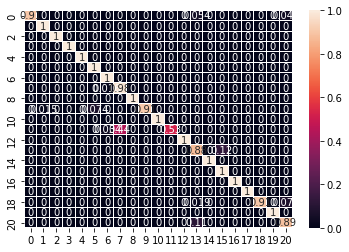

In [ ]:
print(metrics.classification_report(test_labels, y_pred))

confusion_dl = confusion_matrix(test_labels, y_pred)

cm_normalized_dl = confusion_dl.astype('float') / confusion_dl.sum(axis=1)[:, np.newaxis]

print("\n Confusion Matrix:\n")
sns.heatmap(cm_normalized_dl, annot=True, linewidths = 0.01)

In [ ]:
temp = df[df['cluster']==8]
temp

,Question,Answer,cluster,label
552,what should i take,"Pardon, may i suggest you a red velvet.",8.0,suggestion
553,what u have,"Pardon, may i suggest you a hazelnut cappccino.",8.0,suggestion
554,what u have,"Pardon, may i suggest you a cafe mocha.",8.0,suggestion
555,what u have,"Pardon, may i suggest you a cappccino.",8.0,suggestion
556,what you have,"Pardon, may i suggest you a americano.",8.0,suggestion
...,...,...,...,...
635,suggest me something,I may suggest you Latte Macchiato,8.0,suggestion
636,suggest me something,I may suggest you Latte Macchiato,8.0,suggestion
637,suggest me something,I may suggest you Nutella Puff,8.0,suggestion
638,suggest me something,I may suggest you Vanila Layer,8.0,suggestion


In [ ]:
temp = df[df['cluster']==12]
temp

,Question,Answer,cluster,label
752,anything special,"We have coffee,pastries,puff pastries and milk...",12.0,have like milkshakeswhat
753,suggest something,"We have coffee,pastries,puff pastries and milk...",12.0,have like milkshakeswhat
754,anything special,"We have coffee,pastries,puff pastries and milk...",12.0,have like milkshakeswhat
755,suggest something,"We have coffee,pastries,puff pastries and milk...",12.0,have like milkshakeswhat
756,anything special,"We have coffee,pastries,puff pastries and milk...",12.0,have like milkshakeswhat
757,suggest something,"We have coffee,pastries,puff pastries and milk...",12.0,have like milkshakeswhat
758,anything special,"We have coffee,pastries,puff pastries and milk...",12.0,have like milkshakeswhat
759,suggest something,"We have coffee,pastries,puff pastries and milk...",12.0,have like milkshakeswhat
760,can u serve me,"We have coffee,pastries,puff pastries and milk...",12.0,have like milkshakeswhat
761,what is in the menu,"we have pastery , puff-pastery,coffee and milk...",12.0,have like milkshakeswhat


# Chabot Testing


In [ ]:
def clean_text(text): 
  tokens = nltk.word_tokenize(text)
  tokens = [lemmatizer.lemmatize(word) for word in tokens]
  return tokens

In [ ]:
def bag_of_words(text, vocab): 
  tokens = clean_text(text)
  bow = [0] * len(vocab)
  for w in tokens: 
    for idx, word in enumerate(vocab):
      if word == w: 
        bow[idx] = 1
  return np.array(bow)

In [ ]:
def pred_class(text, vocab, labels): 
  bow = bag_of_words(text, vocab)
  result = model.predict(np.array([bow]))[0]
  thresh = 0.2
  y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]

  y_pred.sort(key=lambda x: x[1], reverse=True)
  return_list = []
  for r in y_pred:
    return_list.append(labels[r[0]])
  return return_list

In [ ]:
def get_response(intents_list, intents_json): 
  tag = intents_list[0]
  list_of_intents = intents_json
#  result = "Sorry I can't find the answer"

#  sample = df[df['cluster']==tag]
#  test  = list(sample['Answer'])
#  result = test[0]

  if tag not in df['cluster']:
    result = "Sorry I can't find the answer"
  else:
    sample = df[df['cluster']==tag]
    test  = list(sample['Answer'])
    result = test[0]

  return result

In [ ]:
# running the chatbot
while True:
  message = input("")
  if message == "exit" or message == "stop": 
    break
  else:
    intents = pred_class(message, words, classes)
    result = get_response(intents, df)
    print(result)
    # print(intents)
    # print(intents[0])


hey
Hello! How may I help you.
anything special
We have coffee,pastries,puff pastries and milkshakes.What would you like to have?
coffee
Yes sir  Simple Coffee ,Cappuchino, Americano, Au Laite ,Au Laite Cappucchino ,Chans Espresso ,Con Panna, Black Coffee, Espresso, Frappe ,French Coffee ,Iced Coffee Late ,Irish Coffee, Latte Macchiato and  Wainans Choco Coffee.What would u like to have?
one simple coffee
Sir thanks for your order. You have ordered successfully
ertra sugar plz
Sure sir, Let me get you sugar.
puff pastries
Yes we have your choice in our cafe.
puff
Yes sir  we have Tanuki,Tomato Cheese,Blueberry Puff,Char Sui,Cinnimon Orange rolls,Easy Spinach,French Pastery,Beef Wellington,Keto Puff,Nutella Puff,Asparagus Puff,Egg Puff,Rough Puff,Simple Cherry Puff,Tart Social,Blaeter  tertei Puff.What would u like to have?
one tomato cheese
Sir thanks for your order. You have ordered successfully
thank you
No Problem
exit
